# 基于经典网络架构训练图像分类模型

### 数据预处理部分：

- 数据增强：torchvision中transforms模块自带功能，比较实用
- 数据预处理：torchvision中transforms也帮我们实现好了，直接调用即可
- DataLoader模块直接读取batch数据

### 网络模块设置：

- 加载预训练模型，torchvision中有很多经典网络架构，调用起来十分方便，并且可以用人家训练好的权重参数来继续训练，也就是所谓的迁移学习
- 需要注意的是别人训练好的任务跟咱们的可不是完全一样，需要把最后的head层改一改，一般也就是最后的全连接层，改成咱们自己的任务
- 训练时可以全部重头训练，也可以只训练最后咱们任务的层，因为前几层都是做特征提取的，本质任务目标是一致的

### 网络模型保存与测试
- 模型保存的时候可以带有选择性，例如在验证集中如果当前效果好则保存
- 读取模型进行实际测试

## import

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms,models,datasets


from PIL import Image
import imageio
import json
import copy
import sys
import os
import time

## 数据

In [5]:
data_transforms = {
    "train": transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(45), # -45 至 45,
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomGrayscale(p=0.5),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.255]), # 和模型一致
    ]),
    "valid": transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255]),
    ])
}

data_dir = "./dataset/flower_data/"
train_dir = "train"
test_dir = "valid"

batch_size = 32

datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x]) for x in [train_dir, test_dir]}
dataloader = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=True) for x in [train_dir, test_dir]}

datasize = {x: len(datasets[x]) for x in [train_dir, test_dir]}
classes = datasets["train"].classes

# 读取classes对应的分类名，比如1->"pink premrose"
with open(os.path.join(data_dir, "cat_to_name.json"), "r") as f:
    classes_name = json.load(f)
classes_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

## 展示数据

In [6]:
def im_convert(tensor_img):
    img = tensor_img.clone().detach().numpy() # clone()：拷贝为新的地址，但是梯度和原有的关联，detach()和clone()相反
    img = img.squeeze() # squeeze 将多余的维度去掉，比如(1,3,2,1) -> (3,2) # 这一步可以省略
    img = img.transpose(1,2,0) # tensor格式的图片(3,h,w) -> (h,w,3)
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) # 将normalize的图片还原
    img = img.clip(0, 1)
    return img

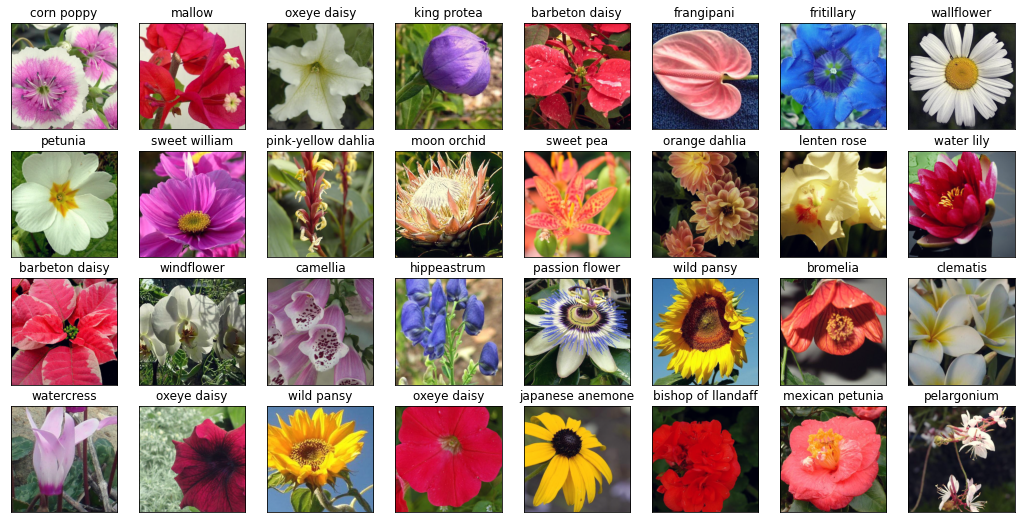

In [7]:
fig = plt.figure(figsize=(18,9))
c,r= 8,4

dataiter = iter(dataloader["valid"])
inputs,classes_ = next(dataiter)
for index,img_tensor in enumerate(inputs):
    plt.subplot(r,c, index+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im_convert(img_tensor))
    plt.title(classes_name[str(classes_[index].item())])
    

## 训练准备

In [20]:
def setParamRequiresGrad(model, isextract):
    if isextract:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, n_classes, feature_extract=True, use_pretrained=True):
    """
    model_name: 根据模型名选择下载的模型
    use_pretrained: 是否是预训练的模型
    n_classes: 任务所需分类的个数，用于调整下载模型全连接层
    feature_extract: 是否冻结全连接之前的层，如果为true表示除了全连接层，其他用别人训练好的参数
    """
    # 选择模型
    if model_name == 'resnet':
        model=models.resnet152(pretrained=use_pretrained)
    
        # feature_extract
        setParamRequiresGrad(model, feature_extract)

        # 改变模型fc
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, n_classes),
            nn.LogSoftmax(dim=1),
        )

        # input_size
        input_size = 224
    return model, input_size

# 训练设备
device = torch.device("dml")

# 模型
feature_extract = True
ispretrained = True
model, _ = initialize_model(model_name="resnet", n_classes=len(classes), feature_extract=feature_extract, use_pretrained=ispretrained)
model = model.to(device)
# model.fc
model_save_name = "checkpoint.pth" # 选取最好的训练结果保存

# 更新权重的层
params_to_update = []
names_params_to_update = []
if feature_extract:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            names_params_to_update.append(name)
else:
    params_to_update = list(map(lambda x: x[0],list(model.named_parameters())))
print("names_params_to_update:", names_params_to_update)
model.fc

names_params_to_update: ['fc.0.weight', 'fc.0.bias']


Sequential(
  (0): Linear(in_features=2048, out_features=102, bias=True)
  (1): LogSoftmax(dim=1)
)

In [21]:
# 优化器设置
lr = 1e-2
optimizer = optim.Adam(params=params_to_update, lr=lr, )
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1) # step_size: 每step_size epoch 学习率是原来的0.1

# 损失函数
cost = nn.NLLLoss()

# epoch
n_epochs = 10

## 训练开始

In [40]:
model, valid_acc_hist, train_acc_hist, valid_losses, train_losses, lrs = train_model(model, dataloader, optimizer, cost, n_epochs, model_save_name , device=device)

Epoch 0/9
----------
Time elapsed 3m 0s
train Loss: 3.0435 Acc: 0.6111
Time elapsed 4m 4s
valid Loss: 2.2669 Acc: 0.7029
Optimizer learning rate : 0.0100000

Epoch 1/9
----------
Time elapsed 7m 2s
train Loss: 2.8943 Acc: 0.6583
Time elapsed 7m 16s
valid Loss: 2.7191 Acc: 0.6919
Optimizer learning rate : 0.0100000

Epoch 2/9
----------
Time elapsed 12m 27s
train Loss: 3.0547 Acc: 0.6543
Time elapsed 12m 55s
valid Loss: 2.1414 Acc: 0.7604
Optimizer learning rate : 0.0100000

Epoch 3/9
----------
Time elapsed 15m 53s
train Loss: 2.8111 Acc: 0.6958
Time elapsed 16m 7s
valid Loss: 2.2463 Acc: 0.7457
Optimizer learning rate : 0.0100000

Epoch 4/9
----------
Time elapsed 20m 56s
train Loss: 2.8789 Acc: 0.6963
Time elapsed 21m 29s
valid Loss: 2.0192 Acc: 0.7958
Optimizer learning rate : 0.0100000

Epoch 5/9
----------
Time elapsed 24m 24s
train Loss: 2.7324 Acc: 0.7181
Time elapsed 24m 39s
valid Loss: 2.0569 Acc: 0.8044
Optimizer learning rate : 0.0100000

Epoch 6/9
----------
Time elapsed 27

## 草稿

In [ ]:
arr = torch.tensor([[0.4,0.6,0.2],[0.2,0.1,0.3]])
a,b=torch.max(arr,1)
a,b

In [47]:
dataiter = iter(dataloader['train'])
data = dataiter.next()

inputs,targets = data
inputs.size()[0]

32

In [50]:
len(dataloader['train'])

205